In [1]:
# necessary imports 
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import copy
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
from torchvision.transforms.transforms import Resize
config = dict(
    DATA_PATH = "cifar-dataset",
    lr = 0.001,
    EPOCHS = 12,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 64,
    pin_memory = True,
    num_workers = 2,
    SEED = 42,
    GPU_ID=0,
    val_split = 0.2
)
device = torch.device(f'cuda:{config["GPU_ID"]}' if torch.cuda.is_available() else 'cpu')
print(device)

config['DEVICE'] = device

torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])


transformations = {
  'general':torchvision.transforms.Compose([
          torchvision.transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
          torchvision.transforms.ToTensor(),
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'train':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'test':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

cuda:0


In [3]:
# get the dataset
traindata = torchvision.datasets.CIFAR10(root=config['DATA_PATH'],train=True,download=True,transform = transformations['general'])
testdata = torchvision.datasets.CIFAR10(root= config['DATA_PATH'],train=False,download=True,transform = transformations['general'])

train_len = len(traindata)
val_len = int(config['val_split'] * train_len)
effective_train_len = train_len - val_len 

train_data,validate_data = torch.utils.data.dataset.random_split(traindata,[effective_train_len,val_len])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
test_loader = torch.utils.data.DataLoader(dataset=testdata,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar-dataset/cifar-10-python.tar.gz to cifar-dataset
Files already downloaded and verified


In [4]:
print(traindata.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [5]:
print(len(train_loader)*config['BATCH_SIZE'])
print(len(validate_loader)*config['BATCH_SIZE'])
print(len(test_loader)*config['BATCH_SIZE'])

40000
10016
10016


In [18]:
# model making

class model1(torch.nn.Module):
  def __init__(self,in_channels = 3,n_class=10,pooling=2):
    super(model1,self).__init__()
    self.n_class= n_class
    self.conv1 = torch.nn.Conv2d(in_channels=in_channels,out_channels=128,kernel_size=(3,3))
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(pooling,pooling),stride=pooling)
    self.relu1 = nn.ReLU()
    self.conv2 = torch.nn.Conv2d(in_channels=128,out_channels=64,kernel_size=(3,3))
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2,2),stride=2)
    self.relu2 = nn.ReLU()
    self.conv3 = torch.nn.Conv2d(in_channels=64,out_channels = 32,kernel_size=(3,3))
    self.maxpool3 = torch.nn.MaxPool2d(kernel_size=(2,2),stride=2)
    self.relu3 = nn.ReLU()

    # output layer
    self.aap = nn.AdaptiveAvgPool2d((8,8))
    self.fc1 = torch.nn.Linear(in_features=32*8*8,out_features=self.n_class)

  def forward(self,x):
    x = self.conv1(x)
    x = self.relu1(self.maxpool1(x))
    x = self.conv2(x)
    x = self.relu2(self.maxpool2(x))
    x = self.conv3(x)
    x = self.relu3(self.maxpool3(x))
    # x => [B,32,H,w] => [B,32 * H * W]
    x = self.aap(x)
    x = torch.flatten(x,start_dim=1)
    x = self.fc1(x)
    return x

class model2(torch.nn.Module):
  def __init__(self,in_channels = 3,n_class=10,pooling=2):
    super(model2,self).__init__()
    self.n_class = n_class
    self.conv1 = torch.nn.Conv2d(in_channels=in_channels,out_channels=128,kernel_size=(3,3))
    self.conv2 = torch.nn.Conv2d(in_channels=128,out_channels=64,kernel_size=(3,3))
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=pooling,stride=pooling)
    self.relu1 = nn.ReLU()
    self.conv3 = torch.nn.Conv2d(in_channels=64,out_channels = 32,kernel_size=(3,3))
    self.conv4 = torch.nn.Conv2d(in_channels=32,out_channels = 16,kernel_size=(3,3))
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=pooling,stride=pooling)
    self.relu2 = nn.ReLU()

    # output layer
    self.aap = nn.AdaptiveAvgPool2d((8,8))
    self.fc1 = torch.nn.Linear(in_features=16*8*8,out_features=self.n_class)

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.relu1(self.maxpool1(x))
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.relu2(self.maxpool2(x))
    # x => [B,32,H,w] => [B,32 * H * W]
    x = self.aap(x)
    x = torch.flatten(x,start_dim=1)
    x = self.fc1(x)
    return x

class model3(torch.nn.Module):
  def __init__(self,in_channels = 3,n_class=10,pooling=2):
    super(model3,self).__init__()
    self.n_class = n_class
    self.conv1 = torch.nn.Conv2d(in_channels=in_channels,out_channels=128,kernel_size=(3,3))
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=pooling,stride=pooling)
    self.relu1 = nn.ReLU()
    self.conv2 = torch.nn.Conv2d(in_channels=128,out_channels=64,kernel_size=(3,3))
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
    self.relu2 = nn.ReLU()
    self.conv3 = torch.nn.Conv2d(in_channels=64,out_channels = 32,kernel_size=(3,3))
    self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
    self.relu3 = nn.ReLU()

    # output layer
    self.aap = nn.AdaptiveAvgPool2d((8,8))
    self.fc1 = torch.nn.Linear(in_features=32*8*8,out_features=512)
    self.relu4 = nn.ReLU()
    self.fc2 = torch.nn.Linear(in_features=512,out_features=128)
    self.relu5 = nn.ReLU()
    self.fc3 = torch.nn.Linear(in_features = 128,out_features=n_class)

  def forward(self,x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.relu2(x)
    x = self.conv3(x)
    x = self.maxpool3(x)
    x = self.relu3(x)
    # x => [B,32,H,w] => [B,32 * H * W]
    x = self.aap(x)
    x = torch.flatten(x,start_dim=1)
    x = self.fc1(x)
    x = self.relu4(x)
    x = self.fc2(x)
    x = self.relu5(x)
    x = self.fc3(x)
    return x

In [7]:
def train(model,lossfunction,optimizer,n_epochs=200):
  tval = {'valloss':[],'valacc':[],'trainacc':[],"trainloss":[]}
  starttime = time.time()
  for epochs in range(n_epochs):
      model.train()
      cur_loss = 0
      curacc = 0
      len_train = len(train_loader)
      for idx , (data,target) in enumerate(train_loader):
          data = transformations['train'](data)    
          data = data.to(device)
          target = target.to(device)
          # model = model.to(device)

          scores = model(data)    
          loss = lossfunction(scores,target)
          cur_loss += loss.item() / (len_train)
          scores = F.softmax(scores,dim = 1)
          _,predicted = torch.max(scores,dim = 1)
          correct = (predicted == target).sum()
          samples = scores.shape[0]
          curacc += correct / (samples * len_train)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          print('TrainBatchDone:{:d}'.format(idx),end='\r') 
  
      model.eval()

      valacc = 0;valloss = 0
      for idx ,(data,target) in enumerate(validate_loader):
          
          data = transformations['val'](data)
          data = data.to(device)
          target = target.to(device)
          # model = model.to(device)

          correct = 0;samples=0
          with torch.no_grad():
              scores = model(data)
              loss = lossfunction(scores,target)
              scores =F.softmax(scores,dim=1)
              _,predicted = torch.max(scores,dim = 1)
              correct += (predicted == target).sum()
              samples += scores.shape[0]
              valloss += loss.item() / len(validate_loader)
              valacc += correct / (samples * len(validate_loader))
              # torch.cuda.empty_cache(self.gpu_id)

          print('ValidnBatchDone:{:d}'.format(idx),end='\r') 


      model.train()
      
      # print(correct.get_device(),samples.get_device(),len(validate_loader).get_device())
      tval['valloss'].append(float(valloss))
      tval['valacc'].append(float(valacc))
      tval['trainacc'].append(float(curacc))
      tval['trainloss'].append(float(cur_loss))
      
      print('epoch:[{:d}/{:d}], TrainAcc:{:.3f}, TrainLoss:{:.3f}, ValAcc:{:.3f}, ValLoss:{:.3f}'.format(epochs+1,n_epochs,curacc,cur_loss,valacc,valloss)) 

  time2 = time.time() - starttime
  print('done time {:.3f} hours'.format(time2/3600))
  return tval

def getparams(model):
    total_parameters = 0
    for name,parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        total_parameters += param
    print(f"total_trainable_parameters are : {total_parameters}")

def loss_acc_curve(tval):
    # print(tval['trainacc'])
    figure,ax=plt.subplots(1,2,figsize=(18,5))
    ax[0].plot(list(range(1,config['EPOCHS']+1)),tval['trainloss'],color='orange',label='train_loss')
    ax[0].plot(list(range(1,config['EPOCHS']+1)),tval['valloss'],color='blue',label='validation_loss')
    ax[0].legend()
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
    ax[0].set_title('loss curve')
  # plt.show()

    ax[1].plot(list(range(1,config['EPOCHS']+1)),tval['trainacc'],color='orange',label='train_acc')
    ax[1].plot(list(range(1,config['EPOCHS']+1)),tval['valacc'],color='blue',label='validation_acc')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("accuracy")
    ax[1].legend()
    ax[1].set_title('accuracy curve')
    
    plt.show()
#   plt.plot(list(range(1,config['EPOCHS']+1)),tval['trainloss'],color='orange',label='train_loss')
#   plt.plot(list(range(1,config['EPOCHS']+1)),tval['valloss'],color='blue',label='validation_loss')
#   plt.legend()
#   plt.xlabel("epochs")
#   plt.ylabel("loss")
#   plt.show()

#   plt.plot(list(range(1,config['EPOCHS']+1)),tval['trainacc'],color='orange',label='train_acc')
#   plt.plot(list(range(1,config['EPOCHS']+1)),tval['valacc'],color='blue',label='validation_acc')
#   plt.xlabel("epochs")
#   plt.ylabel("accuracy")
#   plt.legend()
#   plt.show()

def plot_roc(fpr_tpr_auc): # name can be test train or validation
  plt.figure(figsize=(7,6))
  for i in range(10):
    fpr,tpr,aucc = fpr_tpr_auc[i]
    plt.plot(fpr,tpr,label = 'auc{:d}:{:.2f}'.format(i,aucc))
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend()
    plt.title('ROC')
  plt.show() 

def getparams(model):
  fpr_tpr_auc = {}
  total_parameters = 0
  for name,parameter in model.named_parameters():
      if not parameter.requires_grad:
          continue
      param = parameter.numel()
      total_parameters += param
  print(f"total_trainable_parameters are : {total_parameters}")


def evaluate(model,loader,name='test'):
  model.eval()
  correct = 0;samples =0
  fpr_tpr_auc = {}
  pre_prob = []
  lab = []
  predicted_labels = []

  with torch.no_grad():
      for idx,(x,y) in enumerate(loader):
          x = transformations['test'](x)
          x = x.to(device)
          y = y.to(device)
          # model = model.to(device)

          scores = model(x)
          predict_prob = F.softmax(scores)
          _,predictions = predict_prob.max(1)

          predictions = predictions.to('cpu')
          y = y.to('cpu')
          predict_prob = predict_prob.to('cpu')

          predicted_labels.extend(list(predictions.numpy()))
          pre_prob.extend(list(predict_prob.numpy()))
          lab.extend(list(y.numpy()))

          correct += (predictions == y).sum()
          samples += predictions.size(0)

          print('batches done : ',idx,end='\r')
      
      print('correct are {:.2f}'.format(correct/samples))
      
#     fpr_tpr_auc[f'fpr_{name}'], fpr_tpr_auc[f'tpr_{name}'], _ = roc_curve(lab,pre_prob[:,1])
#     fpr_tpr_auc[f'auc_{name}'] = auc(fpr_tpr_auc[f'fpr_{name}'],fpr_tpr_auc[f'tpr_{name}'])
  y_binarize = label_binarize(lab,classes=[i for i in range(10)])
  pre_prob = np.array(pre_prob)
  for i in range(10):
    fpr,tpr,_ = roc_curve(y_binarize[:,i],pre_prob[:,i])
    aucc = auc(fpr,tpr)
    fpr_tpr_auc[i] = [fpr,tpr,aucc]
  model.train()
  return fpr_tpr_auc

total_trainable_parameters are : 116330
epoch:[1/12], TrainAcc:0.482, TrainLoss:1.454, ValAcc:0.580, ValLoss:1.201
epoch:[2/12], TrainAcc:0.607, TrainLoss:1.133, ValAcc:0.621, ValLoss:1.084
epoch:[3/12], TrainAcc:0.644, TrainLoss:1.030, ValAcc:0.634, ValLoss:1.050
epoch:[4/12], TrainAcc:0.664, TrainLoss:0.968, ValAcc:0.644, ValLoss:1.019
epoch:[5/12], TrainAcc:0.683, TrainLoss:0.920, ValAcc:0.665, ValLoss:0.987
epoch:[6/12], TrainAcc:0.693, TrainLoss:0.887, ValAcc:0.657, ValLoss:0.982
epoch:[7/12], TrainAcc:0.707, TrainLoss:0.851, ValAcc:0.661, ValLoss:1.023
epoch:[8/12], TrainAcc:0.713, TrainLoss:0.828, ValAcc:0.655, ValLoss:1.001
epoch:[9/12], TrainAcc:0.723, TrainLoss:0.808, ValAcc:0.662, ValLoss:0.986
epoch:[10/12], TrainAcc:0.726, TrainLoss:0.793, ValAcc:0.669, ValLoss:0.971
epoch:[11/12], TrainAcc:0.731, TrainLoss:0.778, ValAcc:0.669, ValLoss:0.973
epoch:[12/12], TrainAcc:0.732, TrainLoss:0.765, ValAcc:0.672, ValLoss:0.979
done time 0.149 hours
correct are 0.67


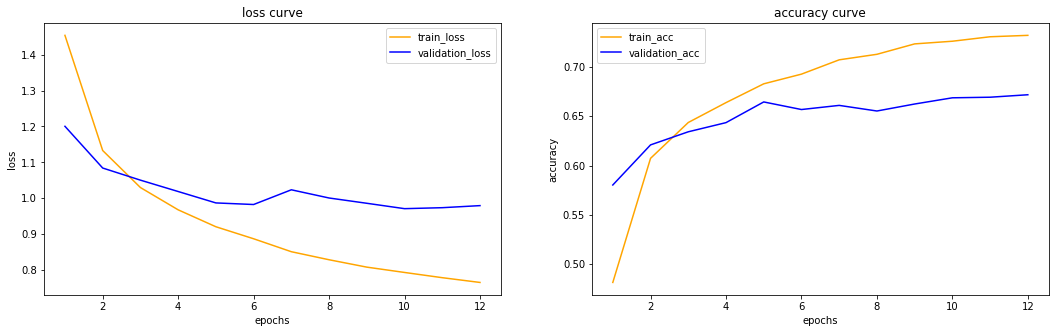

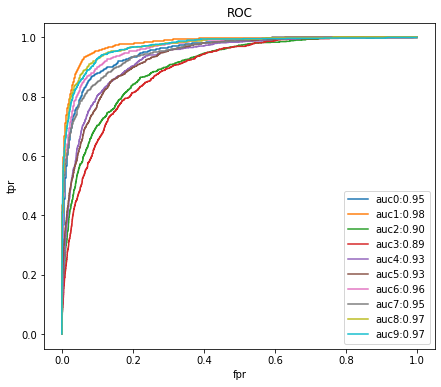

In [14]:
torchmodel = model1()
torchmodel = torchmodel.to(device)
# print(torchmodel)
lossfunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=torchmodel.parameters(),lr=config['lr'])

getparams(torchmodel)
history = train(torchmodel,lossfunction,optimizer,n_epochs=config['EPOCHS'])

train_fta = evaluate(torchmodel,test_loader,name='test')
loss_acc_curve(history)
plot_roc(train_fta)

total_trainable_parameters are : 110714
epoch:[1/12], TrainAcc:0.456, TrainLoss:1.528, ValAcc:0.579, ValLoss:1.210
epoch:[2/12], TrainAcc:0.587, TrainLoss:1.189, ValAcc:0.620, ValLoss:1.087
epoch:[3/12], TrainAcc:0.629, TrainLoss:1.073, ValAcc:0.634, ValLoss:1.052
epoch:[4/12], TrainAcc:0.653, TrainLoss:1.006, ValAcc:0.660, ValLoss:0.986
epoch:[5/12], TrainAcc:0.665, TrainLoss:0.968, ValAcc:0.651, ValLoss:1.004
epoch:[6/12], TrainAcc:0.676, TrainLoss:0.938, ValAcc:0.668, ValLoss:0.958
epoch:[7/12], TrainAcc:0.684, TrainLoss:0.917, ValAcc:0.676, ValLoss:0.935
epoch:[8/12], TrainAcc:0.686, TrainLoss:0.906, ValAcc:0.661, ValLoss:0.973
epoch:[9/12], TrainAcc:0.693, TrainLoss:0.881, ValAcc:0.652, ValLoss:1.016
epoch:[10/12], TrainAcc:0.698, TrainLoss:0.876, ValAcc:0.668, ValLoss:0.999
epoch:[11/12], TrainAcc:0.700, TrainLoss:0.865, ValAcc:0.655, ValLoss:0.996
epoch:[12/12], TrainAcc:0.704, TrainLoss:0.853, ValAcc:0.664, ValLoss:1.001
done time 0.306 hours
correct are 0.66


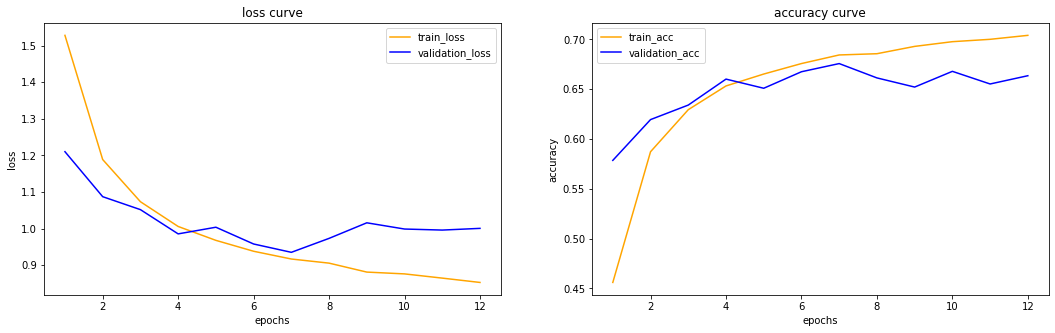

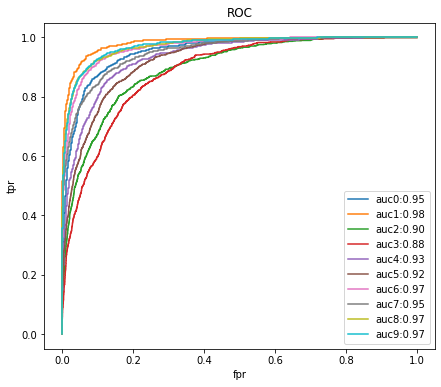

In [9]:
torchmodel = model2()
torchmodel = torchmodel.to(device)
# print(torchmodel)
lossfunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=torchmodel.parameters(),lr=config['lr'])

getparams(torchmodel)
history = train(torchmodel,lossfunction,optimizer,n_epochs=config['EPOCHS'])

train_fta = evaluate(torchmodel,test_loader,name='test')
loss_acc_curve(history)
plot_roc(train_fta)

total_trainable_parameters are : 1211882
epoch:[1/12], TrainAcc:0.476, TrainLoss:1.455, ValAcc:0.573, ValLoss:1.204
epoch:[2/12], TrainAcc:0.627, TrainLoss:1.067, ValAcc:0.662, ValLoss:0.987
epoch:[3/12], TrainAcc:0.691, TrainLoss:0.897, ValAcc:0.681, ValLoss:0.930
epoch:[4/12], TrainAcc:0.729, TrainLoss:0.781, ValAcc:0.672, ValLoss:0.988
epoch:[5/12], TrainAcc:0.760, TrainLoss:0.686, ValAcc:0.688, ValLoss:0.921
epoch:[6/12], TrainAcc:0.791, TrainLoss:0.599, ValAcc:0.690, ValLoss:0.972
epoch:[7/12], TrainAcc:0.813, TrainLoss:0.533, ValAcc:0.689, ValLoss:0.990
epoch:[8/12], TrainAcc:0.834, TrainLoss:0.474, ValAcc:0.689, ValLoss:1.091
epoch:[9/12], TrainAcc:0.858, TrainLoss:0.405, ValAcc:0.691, ValLoss:1.132
epoch:[10/12], TrainAcc:0.874, TrainLoss:0.361, ValAcc:0.676, ValLoss:1.313
epoch:[11/12], TrainAcc:0.889, TrainLoss:0.317, ValAcc:0.688, ValLoss:1.236
epoch:[12/12], TrainAcc:0.898, TrainLoss:0.292, ValAcc:0.677, ValLoss:1.409
done time 0.153 hours
correct are 0.68


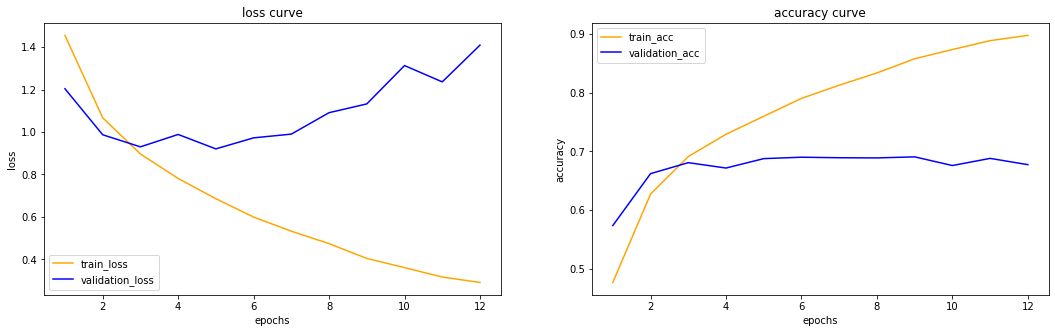

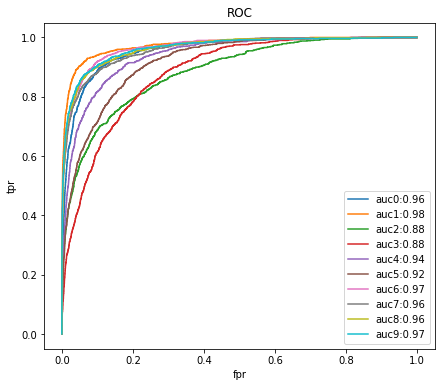

In [10]:
torchmodel = model3()
torchmodel = torchmodel.to(device)
# print(torchmodel)
lossfunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=torchmodel.parameters(),lr=config['lr'])

getparams(torchmodel)
history = train(torchmodel,lossfunction,optimizer,n_epochs=config['EPOCHS'])

train_fta = evaluate(torchmodel,test_loader,name='test')
loss_acc_curve(history)
plot_roc(train_fta)

total_trainable_parameters are : 116330
epoch:[1/12], TrainAcc:0.411, TrainLoss:1.618, ValAcc:0.495, ValLoss:1.410
epoch:[2/12], TrainAcc:0.517, TrainLoss:1.359, ValAcc:0.554, ValLoss:1.273
epoch:[3/12], TrainAcc:0.555, TrainLoss:1.255, ValAcc:0.573, ValLoss:1.198
epoch:[4/12], TrainAcc:0.577, TrainLoss:1.192, ValAcc:0.588, ValLoss:1.159
epoch:[5/12], TrainAcc:0.596, TrainLoss:1.142, ValAcc:0.590, ValLoss:1.156
epoch:[6/12], TrainAcc:0.610, TrainLoss:1.114, ValAcc:0.594, ValLoss:1.149
epoch:[7/12], TrainAcc:0.621, TrainLoss:1.081, ValAcc:0.576, ValLoss:1.209
epoch:[8/12], TrainAcc:0.625, TrainLoss:1.059, ValAcc:0.605, ValLoss:1.133
epoch:[9/12], TrainAcc:0.632, TrainLoss:1.044, ValAcc:0.610, ValLoss:1.132
epoch:[10/12], TrainAcc:0.640, TrainLoss:1.022, ValAcc:0.593, ValLoss:1.172
epoch:[11/12], TrainAcc:0.650, TrainLoss:1.008, ValAcc:0.618, ValLoss:1.090
epoch:[12/12], TrainAcc:0.652, TrainLoss:0.994, ValAcc:0.618, ValLoss:1.098
done time 0.110 hours
correct are 0.62


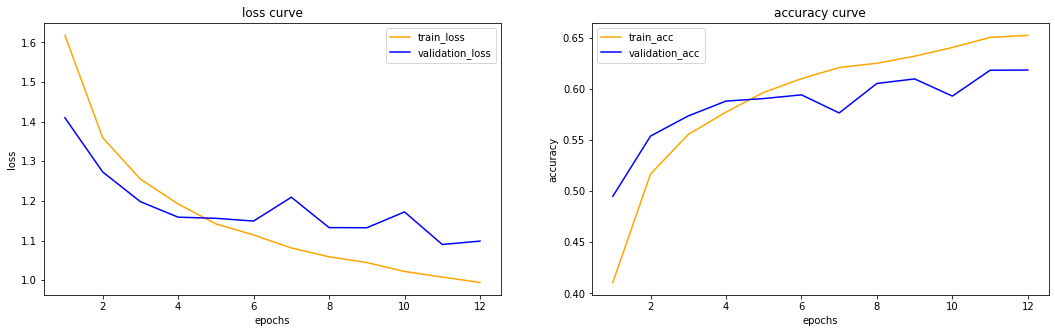

total_trainable_parameters are : 116330
epoch:[1/12], TrainAcc:0.399, TrainLoss:1.655, ValAcc:0.460, ValLoss:1.508
epoch:[2/12], TrainAcc:0.496, TrainLoss:1.407, ValAcc:0.514, ValLoss:1.351
epoch:[3/12], TrainAcc:0.529, TrainLoss:1.319, ValAcc:0.547, ValLoss:1.257
epoch:[4/12], TrainAcc:0.549, TrainLoss:1.263, ValAcc:0.548, ValLoss:1.269
epoch:[5/12], TrainAcc:0.569, TrainLoss:1.217, ValAcc:0.532, ValLoss:1.348
epoch:[6/12], TrainAcc:0.582, TrainLoss:1.182, ValAcc:0.573, ValLoss:1.197
epoch:[7/12], TrainAcc:0.593, TrainLoss:1.158, ValAcc:0.585, ValLoss:1.183
epoch:[8/12], TrainAcc:0.601, TrainLoss:1.140, ValAcc:0.603, ValLoss:1.139
epoch:[9/12], TrainAcc:0.611, TrainLoss:1.110, ValAcc:0.595, ValLoss:1.166
epoch:[10/12], TrainAcc:0.618, TrainLoss:1.097, ValAcc:0.620, ValLoss:1.097
epoch:[11/12], TrainAcc:0.624, TrainLoss:1.073, ValAcc:0.621, ValLoss:1.095
epoch:[12/12], TrainAcc:0.631, TrainLoss:1.055, ValAcc:0.612, ValLoss:1.109
done time 0.104 hours
correct are 0.61


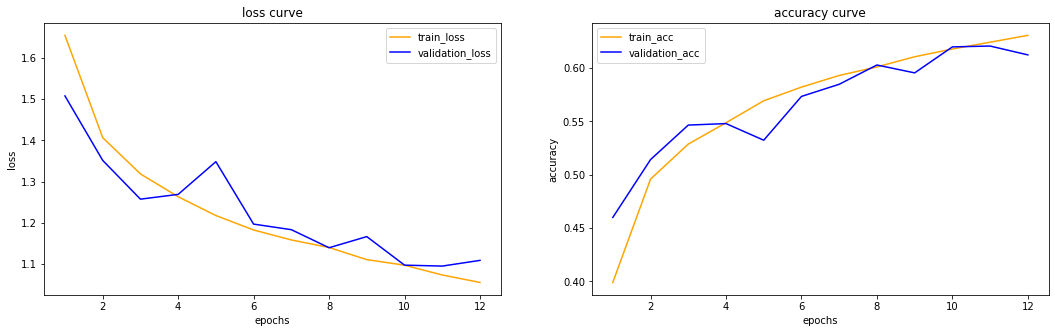

In [15]:
pooling_sz = [3,4]
for p in pooling_sz:
    torchmodel = model1(pooling=p)
    torchmodel = torchmodel.to(device)
    # print(torchmodel)
    lossfunction = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=torchmodel.parameters(),lr=config['lr'])

    getparams(torchmodel)
    history = train(torchmodel,lossfunction,optimizer,n_epochs=config['EPOCHS'])

    train_fta = evaluate(torchmodel,test_loader,name='test')
    loss_acc_curve(history)
    # plot_roc(train_fta)

total_trainable_parameters are : 110714
epoch:[1/12], TrainAcc:0.420, TrainLoss:1.611, ValAcc:0.511, ValLoss:1.350
epoch:[2/12], TrainAcc:0.538, TrainLoss:1.313, ValAcc:0.556, ValLoss:1.253
epoch:[3/12], TrainAcc:0.584, TrainLoss:1.195, ValAcc:0.592, ValLoss:1.178
epoch:[4/12], TrainAcc:0.605, TrainLoss:1.129, ValAcc:0.582, ValLoss:1.193
epoch:[5/12], TrainAcc:0.619, TrainLoss:1.089, ValAcc:0.598, ValLoss:1.149
epoch:[6/12], TrainAcc:0.630, TrainLoss:1.068, ValAcc:0.645, ValLoss:1.023
epoch:[7/12], TrainAcc:0.641, TrainLoss:1.036, ValAcc:0.637, ValLoss:1.046
epoch:[8/12], TrainAcc:0.646, TrainLoss:1.023, ValAcc:0.595, ValLoss:1.179
epoch:[9/12], TrainAcc:0.646, TrainLoss:1.020, ValAcc:0.642, ValLoss:1.037
epoch:[10/12], TrainAcc:0.657, TrainLoss:0.994, ValAcc:0.600, ValLoss:1.133
epoch:[11/12], TrainAcc:0.653, TrainLoss:1.002, ValAcc:0.646, ValLoss:1.003
epoch:[12/12], TrainAcc:0.657, TrainLoss:0.988, ValAcc:0.647, ValLoss:1.020
done time 0.288 hours
correct are 0.64


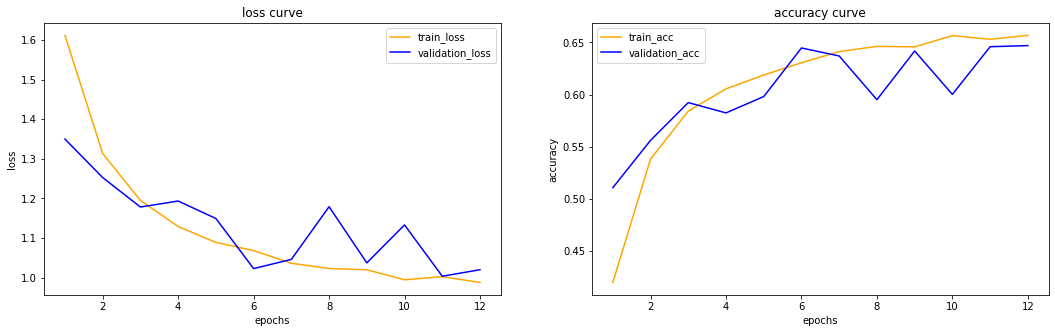

total_trainable_parameters are : 110714
epoch:[1/12], TrainAcc:0.305, TrainLoss:1.855, ValAcc:0.363, ValLoss:1.686
epoch:[2/12], TrainAcc:0.396, TrainLoss:1.649, ValAcc:0.428, ValLoss:1.589
epoch:[3/12], TrainAcc:0.427, TrainLoss:1.578, ValAcc:0.433, ValLoss:1.564
epoch:[4/12], TrainAcc:0.451, TrainLoss:1.515, ValAcc:0.463, ValLoss:1.507
epoch:[5/12], TrainAcc:0.460, TrainLoss:1.494, ValAcc:0.458, ValLoss:1.495
epoch:[6/12], TrainAcc:0.472, TrainLoss:1.464, ValAcc:0.479, ValLoss:1.484
epoch:[7/12], TrainAcc:0.482, TrainLoss:1.439, ValAcc:0.478, ValLoss:1.461
epoch:[8/12], TrainAcc:0.488, TrainLoss:1.434, ValAcc:0.498, ValLoss:1.428
epoch:[9/12], TrainAcc:0.503, TrainLoss:1.394, ValAcc:0.505, ValLoss:1.382
epoch:[10/12], TrainAcc:0.510, TrainLoss:1.376, ValAcc:0.499, ValLoss:1.391
epoch:[11/12], TrainAcc:0.515, TrainLoss:1.364, ValAcc:0.502, ValLoss:1.402
epoch:[12/12], TrainAcc:0.517, TrainLoss:1.352, ValAcc:0.525, ValLoss:1.335
done time 0.280 hours
correct are 0.52


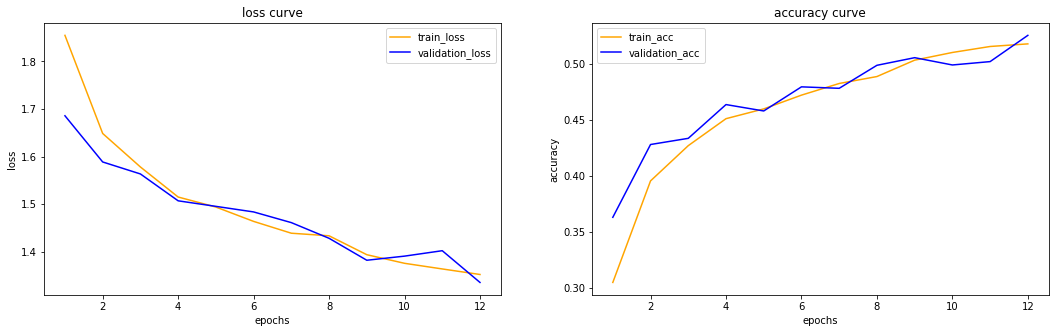

In [16]:
for p in pooling_sz:
    torchmodel = model2(pooling=p)
    torchmodel = torchmodel.to(device)
    # print(torchmodel)
    lossfunction = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=torchmodel.parameters(),lr=config['lr'])

    getparams(torchmodel)
    history = train(torchmodel,lossfunction,optimizer,n_epochs=config['EPOCHS'])

    train_fta = evaluate(torchmodel,test_loader,name='test')
    loss_acc_curve(history)
    # plot_roc(train_fta)

total_trainable_parameters are : 1211882
epoch:[1/12], TrainAcc:0.398, TrainLoss:1.633, ValAcc:0.496, ValLoss:1.379
epoch:[2/12], TrainAcc:0.515, TrainLoss:1.356, ValAcc:0.524, ValLoss:1.332
epoch:[3/12], TrainAcc:0.559, TrainLoss:1.238, ValAcc:0.566, ValLoss:1.244
epoch:[4/12], TrainAcc:0.594, TrainLoss:1.149, ValAcc:0.573, ValLoss:1.219
epoch:[5/12], TrainAcc:0.619, TrainLoss:1.087, ValAcc:0.606, ValLoss:1.136
epoch:[6/12], TrainAcc:0.634, TrainLoss:1.041, ValAcc:0.597, ValLoss:1.187
epoch:[7/12], TrainAcc:0.652, TrainLoss:0.987, ValAcc:0.609, ValLoss:1.141
epoch:[8/12], TrainAcc:0.666, TrainLoss:0.949, ValAcc:0.625, ValLoss:1.114
epoch:[9/12], TrainAcc:0.679, TrainLoss:0.915, ValAcc:0.635, ValLoss:1.078
epoch:[10/12], TrainAcc:0.691, TrainLoss:0.877, ValAcc:0.621, ValLoss:1.126
epoch:[11/12], TrainAcc:0.701, TrainLoss:0.849, ValAcc:0.620, ValLoss:1.133
epoch:[12/12], TrainAcc:0.709, TrainLoss:0.823, ValAcc:0.632, ValLoss:1.130
done time 0.112 hours
correct are 0.62


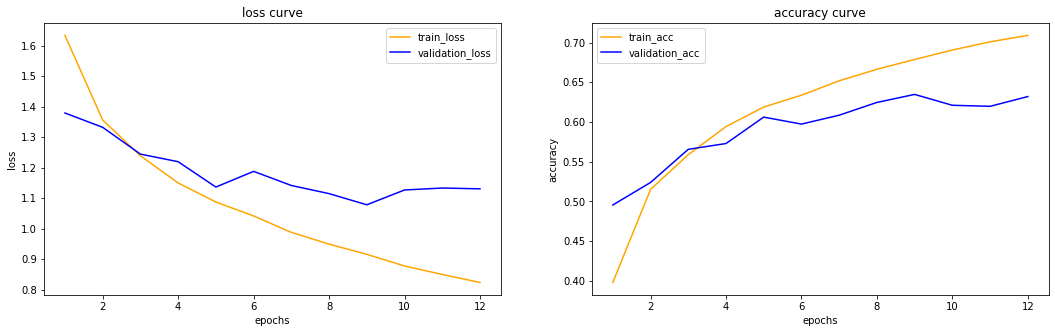

total_trainable_parameters are : 1211882
epoch:[1/12], TrainAcc:0.365, TrainLoss:1.704, ValAcc:0.441, ValLoss:1.489
epoch:[2/12], TrainAcc:0.482, TrainLoss:1.413, ValAcc:0.483, ValLoss:1.394
epoch:[3/12], TrainAcc:0.524, TrainLoss:1.314, ValAcc:0.548, ValLoss:1.268
epoch:[4/12], TrainAcc:0.558, TrainLoss:1.241, ValAcc:0.559, ValLoss:1.233
epoch:[5/12], TrainAcc:0.575, TrainLoss:1.191, ValAcc:0.580, ValLoss:1.205
epoch:[6/12], TrainAcc:0.586, TrainLoss:1.166, ValAcc:0.579, ValLoss:1.193
epoch:[7/12], TrainAcc:0.600, TrainLoss:1.130, ValAcc:0.568, ValLoss:1.255
epoch:[8/12], TrainAcc:0.613, TrainLoss:1.100, ValAcc:0.596, ValLoss:1.154
epoch:[9/12], TrainAcc:0.617, TrainLoss:1.081, ValAcc:0.583, ValLoss:1.200
epoch:[10/12], TrainAcc:0.629, TrainLoss:1.053, ValAcc:0.607, ValLoss:1.150
epoch:[11/12], TrainAcc:0.638, TrainLoss:1.026, ValAcc:0.611, ValLoss:1.129
epoch:[12/12], TrainAcc:0.642, TrainLoss:1.010, ValAcc:0.612, ValLoss:1.127
done time 0.106 hours
correct are 0.61


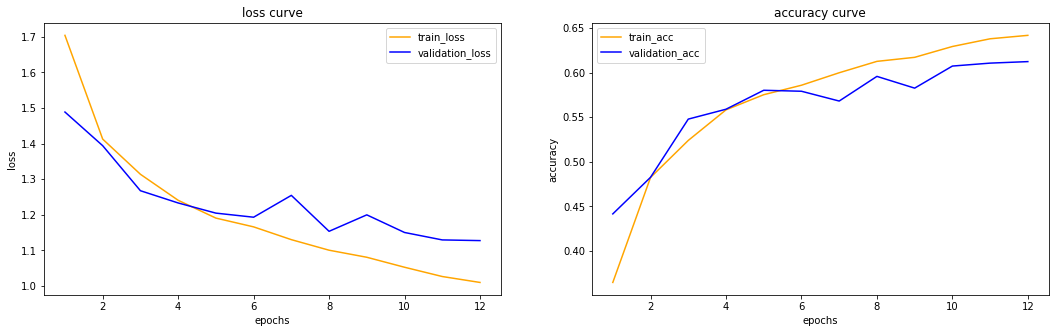

In [19]:
for p in pooling_sz:
    torchmodel = model3(pooling=p)
    torchmodel = torchmodel.to(device)
    # print(torchmodel)
    lossfunction = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=torchmodel.parameters(),lr=config['lr'])

    getparams(torchmodel)
    history = train(torchmodel,lossfunction,optimizer,n_epochs=config['EPOCHS'])

    train_fta = evaluate(torchmodel,test_loader,name='test')
    loss_acc_curve(history)
    # plot_roc(train_fta)